# Part 1. Importing Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
import missingno

import sys
import warnings

import warnings
warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

# Part 2. Defining Functions

In [2]:
# Reference: https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def cross_validator(estimator, X_train, y_train, scoring="accuracy", cv=10, n_jobs=1):
    scores = cross_val_score(estimator, X=X_train, y=y_train, scoring=scoring, cv=cv, n_jobs=n_jobs)
    print(np.round(scores,3), '->', np.round(scores.mean(),3), '|', np.round(scores.std(),3))
    #print("Mean score: {0:.4f} | std: {1:.4f}".format(scores.mean(), scores.std()))
    
    
def grid_search(estimator, params, X, y, scoring='accuracy', cv=10, n_jobs=-1, verbose=1):

    grid_clf = GridSearchCV(estimator, param_grid=params, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_clf.fit(X, y)

    print(grid_clf.best_params_, grid_clf.best_score_)
    
    return grid_clf

# Part 3. Loading Train and Test Data Sets

In [3]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
IDtest = test["PassengerId"]

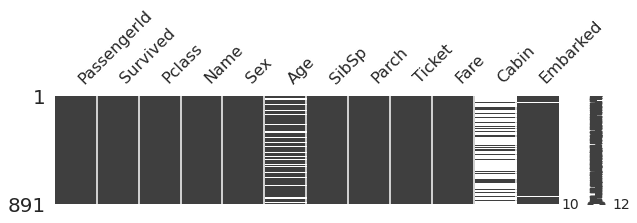

In [4]:
missingno.matrix(train, figsize=(10,2))
plt.show()

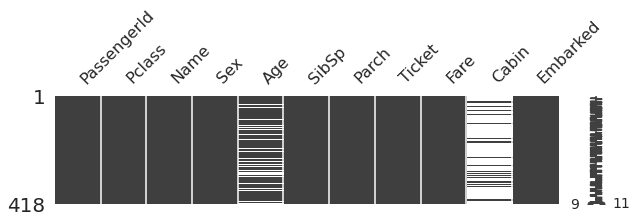

In [5]:
missingno.matrix(test, figsize=(10,2))
plt.show()

## 1. Joining Train and Test sets for Data Manipulations 

In [6]:
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

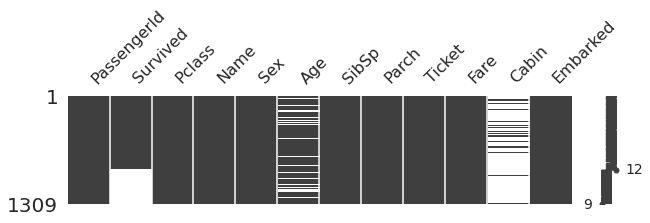

In [7]:
missingno.matrix(dataset, figsize=(10,2))
plt.show()

In [8]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

# Part 4. EDA, Feature Engineering and Creation (Recap)

## 1. Name -> Title feature creation

In [9]:
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [10]:
dataset["Title"] = dataset['Title'].replace(['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 
                                             'the Countess', 'Jonkheer', 'Dona'], 'Rare')

dataset["Title"].value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
Rare       29
Ms          2
Mlle        2
Mme         1
Name: Title, dtype: int64

In [11]:
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1,
                                         "Mr":2, "Rare":3})
dataset['Title'].value_counts()

2    757
1    462
0     61
3     29
Name: Title, dtype: int64

- 0 : Master (10대 미만의 어린 사람들)
- 1 : Ms, Mme, Mlle, Mrs, Miss
- 2 : Mr
- 3 : Rare (귀족 또는 상류층으로 짐작되는 사람들)

## 2. Cabin : Initial Extraction and Missing Values Manipulation

In [12]:
dataset["Cabin"].fillna('X', inplace=True)

In [13]:
dataset["Cabin"] = dataset['Cabin'].str[0]

In [14]:
dataset["Cabin"].value_counts()

X    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

## 3. Embarked: Missing Values

In [15]:
dataset[dataset['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B,NaN,1
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B,NaN,1


- 1등급 손님은 C에서 많이 탄 것은 사실이나 S와 큰 격차를 보이지 않는다. 
- Embarked Missing value를 가지는 두 명의 여성 손님은 모두 1등급 손님이다. 
- C를 부여하는 방법을 생각할 수도 있거나 이 두 손님 데이터를 drop할 수도 있다. 

여기서는 C를 부여하도록 하자. 추후에 drop한 결과와 비교를 해보자.

In [16]:
dataset["Embarked"].fillna('C', inplace=True)

In [17]:
dataset["Embarked"].isnull().sum()

0

## 4. Fare: Missing Values

In [18]:
dataset[dataset['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,X,S,2


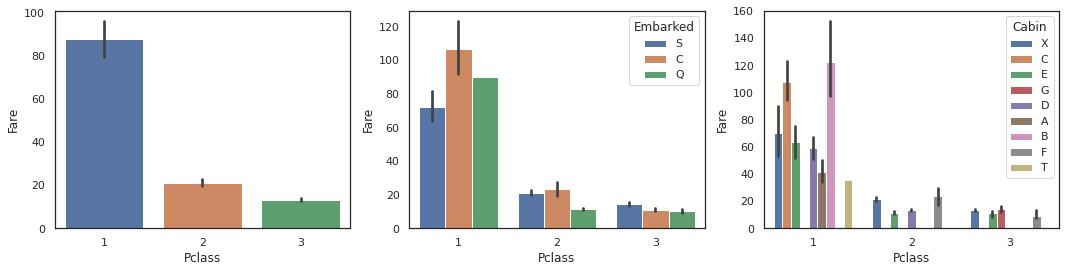

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
sns.barplot(data=dataset, x="Pclass", y="Fare", ax=ax[0])
sns.barplot(data=dataset, x="Pclass", y="Fare", hue='Embarked', ax=ax[1])
sns.barplot(data=dataset, x="Pclass", y="Fare", hue='Cabin', ax=ax[2])
plt.show()

- Pclass 3의 Fare값의 평균은 약 10~20 사이에 있으며 표준편차가 작은 편이라 평균값을 사용할 수 있을 것이다. 
- Fare값이 Missing value인 PassengerId 1044인 남자의 Fare는 Pclass 3의 Fare 평균값으로 대체할 수 있다. 
- 또는 Pclass==3 & Embarked==S의 Fare 평균값으로 할 수도 있다.

In [20]:
FareMean_Pclass3 = dataset[dataset['Pclass']==3].Fare.mean()
dataset["Fare"].fillna(FareMean_Pclass3, inplace=True)

In [21]:
dataset["Fare"].isnull().sum()

0

## 5. Age: Missing Values **

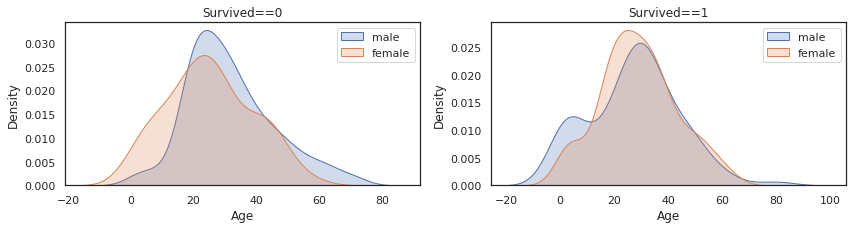

In [22]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,3))
ax0.set_title('Survived==0')
sns.kdeplot(train[(train['Survived']==0) & (train['Sex']=='male')].Age, shade=True, ax=ax0, label="male")
sns.kdeplot(train[(train['Survived']==0) & (train['Sex']=='female')].Age, shade=True, ax=ax0, label="female")
ax0.legend()

ax1.set_title('Survived==1')
sns.kdeplot(train[(train['Survived']==1) & (train['Sex']=='male')].Age, shade=True, ax=ax1, label="male")
sns.kdeplot(train[(train['Survived']==1) & (train['Sex']=='female')].Age, shade=True, ax=ax1, label="female")
ax1.legend(); 
plt.show()

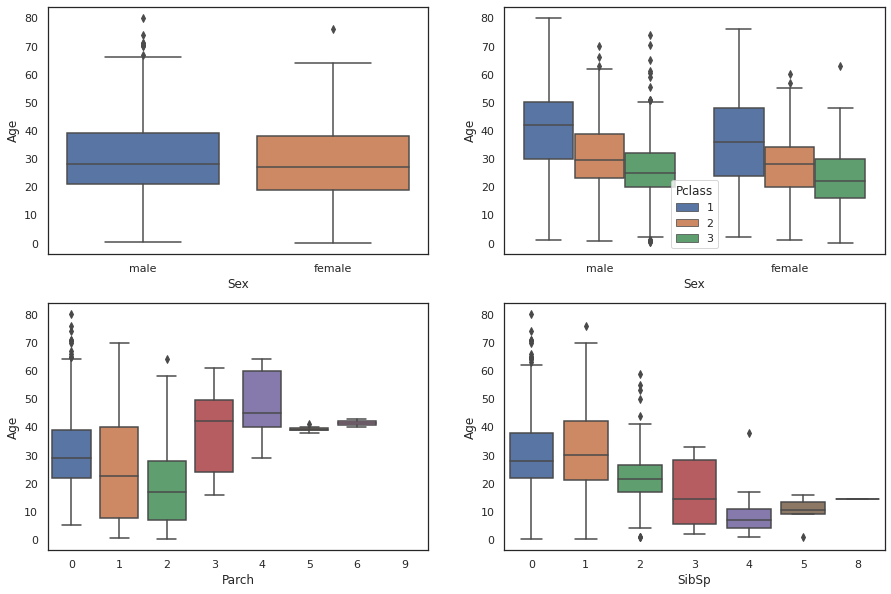

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
sns.boxplot(y="Age",x="Sex",data=dataset, ax=ax[0,0])
sns.boxplot(y="Age",x="Sex",hue="Pclass", data=dataset, ax=ax[0,1])
sns.boxplot(y="Age",x="Parch", data=dataset, ax=ax[1,0])
sns.boxplot(y="Age",x="SibSp", data=dataset, ax=ax[1,1])
plt.show()

- 남녀의 연령 분포는 거의 비슷하다. 
- 1등급, 2등급, 3등급 순으로 연령 분포가 젋어지는 것을 볼 수 있다. 
- Parch의 수가 늘어날수록 (Parch=4까지) 연령분포가 올라가는 것을 알 수 있다. 
- SibSp에서는 연령분포의 큰 차이가 없는 듯 하다. Sibsp>=4인 경우에는 연령대가 낮은 것은 알 수 있다. 

여기에서는 Age missing value는 Ref.를 따라서 생성하도록 한다. 

추후에 가능하면 Age를 예측하는 모델을 만들어 Age값을 생성하는 방법도 고려해보도록 하자. 


Ref:https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook

In [24]:
# Reference: https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook
# Filling missing value of Age 
## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

In [25]:
dataset["Age"].isnull().sum()

0

## 6. Family size Feature Creation

In [26]:
dataset["Family"] = dataset["SibSp"] + dataset["Parch"] + 1

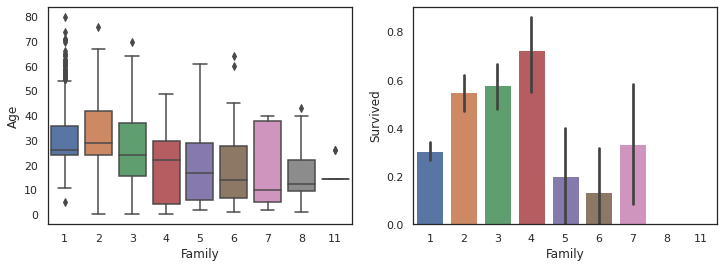

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.boxplot(y="Age",x="Family",data=dataset, ax=ax[0])
sns.barplot(y="Survived",x="Family",data=dataset[:train_len], ax=ax[1])
plt.show()

## 7. Conclusions

In [28]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
 12  Title        1309 non-null   int64  
 13  Family       1309 non-null   int64  
dtypes: float64(3), int64(6), object(5)
memory usage: 143.3+ KB


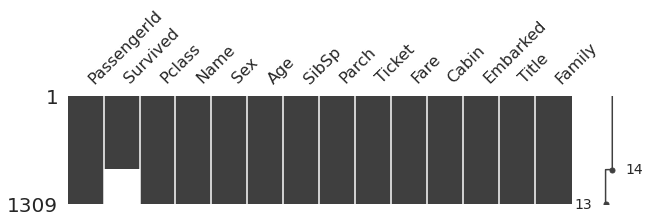

In [29]:
missingno.matrix(dataset, figsize=(10,2))
plt.show()

# Part 5. Feature Selections

- Name, Ticket Features는 사용하지 않는다. 
- Cabin의 경우, 많은 Missing Value를 X로 대체하였다. X의 많은 수가 3등급 Cabin이기 때문에 어느 정도 의미있는 Feature라고 짐작할 수 있지만 확신할 수는 없다. Cabin을 사용하는 여부에 따른 두 가지 결과를 예측할 수 있다.

## 1. Dropping Name and Ticket

In [30]:
dataset.drop(["Name", "Ticket"], axis=1, inplace=True)

In [31]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Sex          1309 non-null   object 
 4   Age          1309 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Fare         1309 non-null   float64
 8   Cabin        1309 non-null   object 
 9   Embarked     1309 non-null   object 
 10  Title        1309 non-null   int64  
 11  Family       1309 non-null   int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 122.8+ KB


## 2. Categorical Feature: One-Hot Encoding

In [32]:
categorical_features = ["Pclass", "Sex", "Cabin", "Embarked", "Title"]
for feature in categorical_features:
    dataset[feature] = dataset[feature].astype('category')

In [33]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1309 non-null   int64   
 1   Survived     891 non-null    float64 
 2   Pclass       1309 non-null   category
 3   Sex          1309 non-null   category
 4   Age          1309 non-null   float64 
 5   SibSp        1309 non-null   int64   
 6   Parch        1309 non-null   int64   
 7   Fare         1309 non-null   float64 
 8   Cabin        1309 non-null   category
 9   Embarked     1309 non-null   category
 10  Title        1309 non-null   category
 11  Family       1309 non-null   int64   
dtypes: category(5), float64(3), int64(4)
memory usage: 79.0 KB


In [34]:
categorical_features = ["Pclass", "Sex", "Cabin", "Embarked", "Title"]
dataset = pd.get_dummies(dataset, columns=categorical_features)

## 3. Drop PassengerId 

In [35]:
dataset.drop(["PassengerId"], axis=1, inplace=True)

In [36]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    float64
 1   Age         1309 non-null   float64
 2   SibSp       1309 non-null   int64  
 3   Parch       1309 non-null   int64  
 4   Fare        1309 non-null   float64
 5   Family      1309 non-null   int64  
 6   Pclass_1    1309 non-null   uint8  
 7   Pclass_2    1309 non-null   uint8  
 8   Pclass_3    1309 non-null   uint8  
 9   Sex_female  1309 non-null   uint8  
 10  Sex_male    1309 non-null   uint8  
 11  Cabin_A     1309 non-null   uint8  
 12  Cabin_B     1309 non-null   uint8  
 13  Cabin_C     1309 non-null   uint8  
 14  Cabin_D     1309 non-null   uint8  
 15  Cabin_E     1309 non-null   uint8  
 16  Cabin_F     1309 non-null   uint8  
 17  Cabin_G     1309 non-null   uint8  
 18  Cabin_T     1309 non-null   uint8  
 19  Cabin_X     1309 non-null  

## 4. Fare : log transformation

In [37]:
dataset["Fare"] = np.log1p(dataset["Fare"])

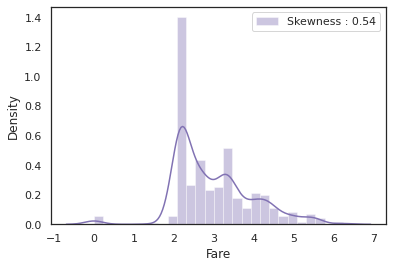

In [38]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g.legend()

## 5. Separating Train and Test Sets after Feature Engineering

In [39]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

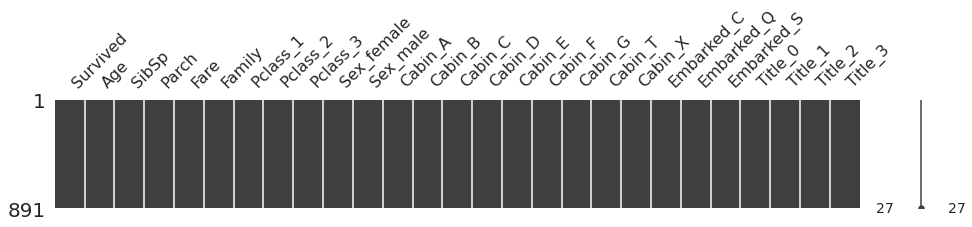

In [40]:
missingno.matrix(train, figsize=(16,2))
plt.show()

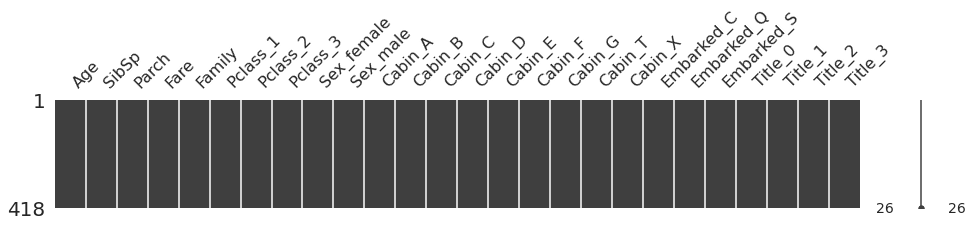

In [41]:
missingno.matrix(test, figsize=(16,2))
plt.show()

In [42]:
y_train = train["Survived"]
X_train = train.drop(labels = ["Survived"],axis = 1)

In [43]:
X_train.describe()

,Age,SibSp,Parch,Fare,Family,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,...,Cabin_G,Cabin_T,Cabin_X,Embarked_C,Embarked_Q,Embarked_S,Title_0,Title_1,Title_2,Title_3
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.063042,0.523008,0.381594,2.962246,1.904602,0.242424,0.206510,0.551066,0.352413,0.647587,...,0.004489,0.001122,0.771044,0.190797,0.086420,0.722783,0.044893,0.349046,0.580247,0.025814
std,13.416641,1.102743,0.806057,0.969048,1.613459,0.428790,0.405028,0.497665,0.477990,0.477990,...,0.066890,0.033501,0.420397,0.393150,0.281141,0.447876,0.207186,0.476936,0.493796,0.158668
min,0.420000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,2.187218,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,2.737881,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,37.000000,1.000000,0.000000,3.465736,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,80.000000,8.000000,6.000000,6.240917,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
y_train.describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

--------------

# Part 6. Machine Learning Modeling

ML모델링을 위해서 다음과 같은 여러 개의 ML 알고리즘을 사용합니다. 

- SVC : Support Vector Machine
- Decision Tree
- Random Forest
- Extra Trees
- AdaBoost
- Gradient Boost
- XGBoost
- Light Gradient Boost Machine (LightGBM)
- Multiple Layer Perceptron (Neural Network)
- KNN
- Logistic Regression
- Linear Discriminant Analysis

위의 ML 모델을 바탕으로 

- cross validation을 이용하여 각 모델를 평가합니다.  
- cross validation 평가 결과를 training set의 평가와 비교하여 under-fitting과 over-fitting 여부를 살펴봅니다. 
- 각 모델의 하이퍼 파라미터를 튜닝합니다. 

## 1. First Modeling

각 ML 모델의 Hyper parameter tuning없이 default값으로만 cross validation을 해봅시다. 

In [45]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

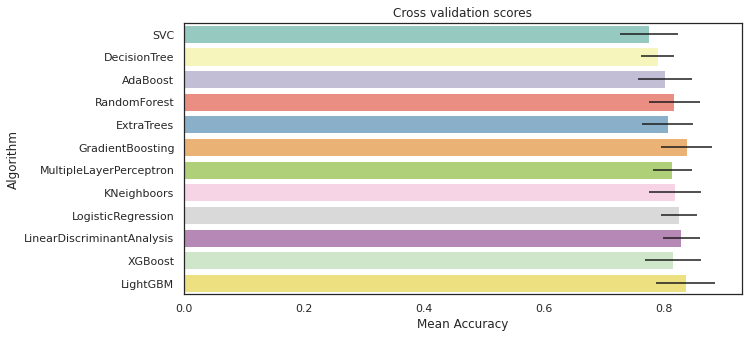

In [46]:
# Ref: https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook

random_state = 1
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(XGBClassifier(random_state=random_state))
classifiers.append(LGBMClassifier(random_state=random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X=X_train, y=y_train, scoring = "accuracy", cv =10, n_jobs=6))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":["SVC","DecisionTree","AdaBoost",
                                    "RandomForest","ExtraTrees","GradientBoosting",
                                    "MultipleLayerPerceptron","KNeighboors",
                                    "LogisticRegression","LinearDiscriminantAnalysis",
                                    "XGBoost", "LightGBM"]})

plt.figure(figsize=(10,5))
sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3", orient = "h",**{'xerr':cv_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")
plt.show()

In [47]:
algorithm = ["SVC", "DecisionTree", "AdaBoost", "RandomForest", "ExtraTrees", "GradientBoosting",
             "MultipleLayerPerceptron","KNeighboors", "LogisticRegression",
             "LinearDiscriminantAnalysis", "XGBoost", "LightGBM"]

for i, cv_result in enumerate(cv_results):
    print("-{0:27s} :".format(algorithm[i]), np.round(cv_result,3), '->', 
          np.round(cv_result.mean(),3), '|', np.round(cv_result.std(),3))

-SVC                         : [0.711 0.73  0.719 0.854 0.775 0.775 0.809 0.73  0.843 0.798] -> 0.774 | 0.049
-DecisionTree                : [0.744 0.798 0.73  0.809 0.809 0.787 0.809 0.787 0.798 0.82 ] -> 0.789 | 0.028
-AdaBoost                    : [0.744 0.809 0.742 0.854 0.865 0.787 0.809 0.742 0.843 0.82 ] -> 0.801 | 0.044
-RandomForest                : [0.778 0.865 0.753 0.82  0.854 0.831 0.798 0.753 0.854 0.865] -> 0.817 | 0.042
-ExtraTrees                  : [0.756 0.831 0.73  0.843 0.831 0.809 0.809 0.753 0.865 0.831] -> 0.806 | 0.042
-GradientBoosting            : [0.822 0.831 0.742 0.843 0.899 0.831 0.854 0.809 0.899 0.843] -> 0.837 | 0.043
-MultipleLayerPerceptron     : [0.822 0.798 0.764 0.865 0.82  0.764 0.798 0.809 0.843 0.854] -> 0.814 | 0.033
-KNeighboors                 : [0.744 0.843 0.764 0.854 0.865 0.764 0.854 0.82  0.865 0.809] -> 0.818 | 0.044
-LogisticRegression          : [0.8   0.854 0.775 0.843 0.831 0.787 0.82  0.82  0.876 0.843] -> 0.825 | 0.03
-LinearDisc

### Learning Curve : underfitting or overfitting?

In [51]:
# Reference: https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

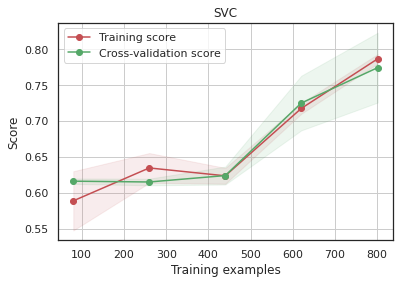

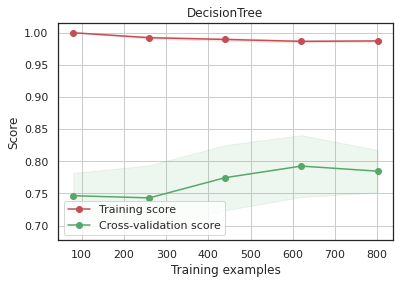

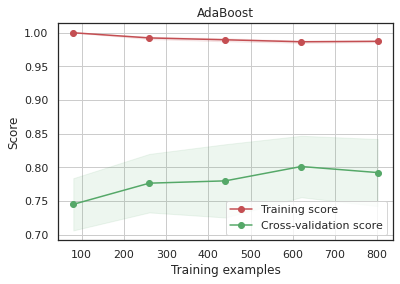

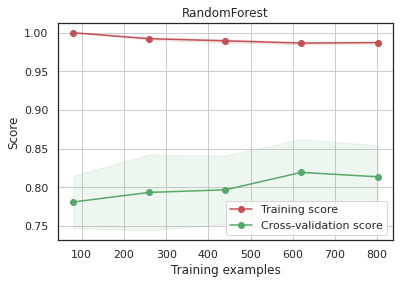

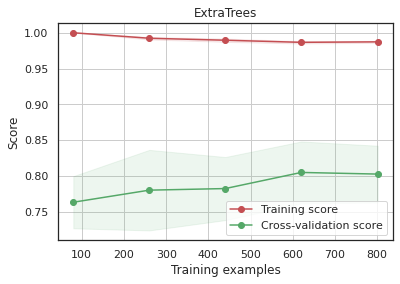

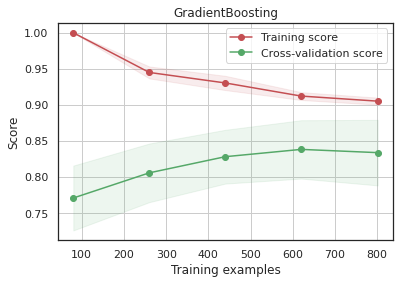

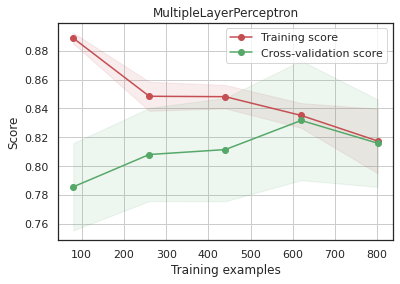

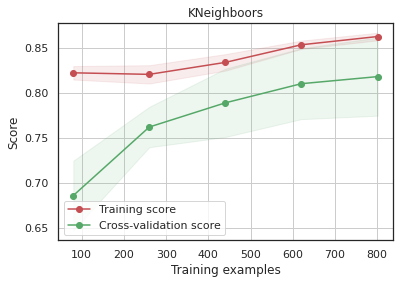

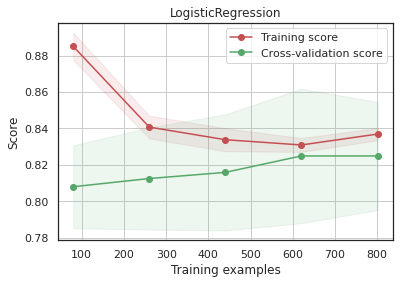

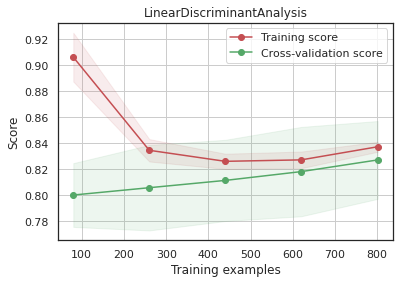

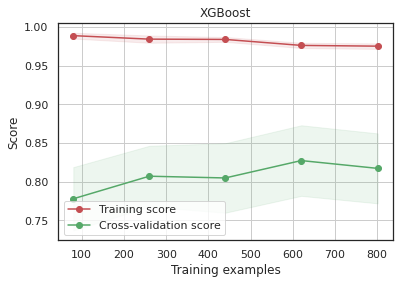

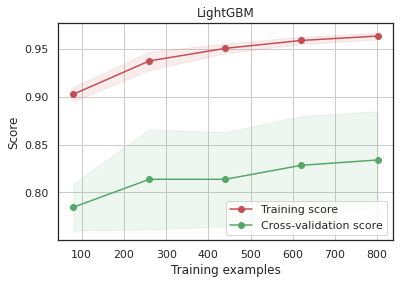

In [110]:
for i, estimator in enumerate(classifiers): 
    g = plot_learning_curve(estimator, algorithm[i], X_train, y_train, cv=10)

#### Observations

다음과 같은 ML 모델들(with default options)은 overfitting(과적합)을 보였다.  
- Decision Tree, AbaBoost, RandomForest, Extra Trees, XGBoost, LightGBM

반면, 다음과 같은 ML모델들은 training과 cross validation의 평가값이 서로 가까웠다. 
- Linear discriminant analysis, Logistic Regression, KNN, MLP, SVC.

SVC의 경우, training score와 cross validation score가 converging하였으나, 전반적인 score가 다른 모델에 비해 낮았다. 

Gradient Boosting의 경우, training score와 cross validation score가 점차 가까워지고 있다. 다른 Boosting모델에 비해 그 차이가 적었다. 

## 2. Hyper Parameter Tuning

몇 개의 ML모델에 대하여 Hyper Parameter tuning을 하도록 하자. 

### 1) Logistic Regression

- 먼저, 가장 고전적인 모델인 Logistic Regression에 대해서 GridSearchCV를 이용하여 튜닝을 하도록 하자. 
- Logistic Regression은 다른 모델에 못지 않은 cross validation score를 기록하였으며 training score와 차이도 크지 않았다. 
- 다만, training score가 감소하는 경향을 보인 점에 주의해야 할 듯 하다. 

In [113]:
lr_clf = LogisticRegression()
params = {'penalty':['l2', 'l1', 'elasticnet'],
          'C':[0.01, 0.03, 0.1, 0.3, 1, 3, 10],
          'l1_ratio':[0.01, 0.03, 0.1, 0.3]}

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=10, n_jobs=6)
grid_clf.fit(X_train, y_train)

print(grid_clf.best_params_, grid_clf.best_score_)

{'C': 1, 'l1_ratio': 0.01, 'penalty': 'l2'} 0.8249438202247191


In [114]:
lr_best = grid_clf.best_estimator_

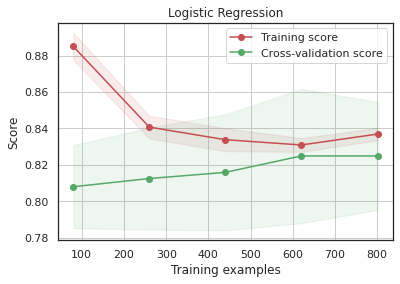

In [115]:
g = plot_learning_curve(lr_best, "Logistic Regression", X_train, y_train, cv=10)

- default model과 비교하였을 때, 큰 변화가 없었다.
- default 모델에서도 이미 training score와 cross-validation score가 거의 근접했었다. 

### 2) Random Forest

### 1st Trial

In [127]:
rf_clf = RandomForestClassifier(random_state=random_state)
params = {"max_depth": [None],
          "max_features": [1, 3, 10],
          "min_samples_split": [2, 3, 10],
          "min_samples_leaf": [1, 3, 10],
          "bootstrap": [False],
          "n_estimators" :[100,300],
          "criterion": ["gini"]}

rf_grid_clf = GridSearchCV(rf_clf, param_grid=params, scoring='accuracy', cv=10, n_jobs=6)
rf_grid_clf.fit(X_train, y_train)

print(rf_grid_clf.best_params_, rf_grid_clf.best_score_)

{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300} 0.8350312109862672


In [128]:
rf_best = rf_grid_clf.best_estimator_

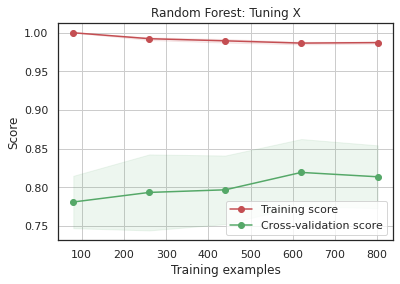

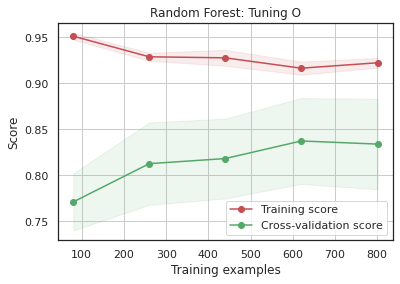

In [130]:
g = plot_learning_curve(RandomForestClassifier(random_state=random_state), 
                        "Random Forest: Tuning X", X_train, y_train, cv=10)
g = plot_learning_curve(rf_best, "Random Forest: Tuning O", X_train, y_train, cv=10)

In [55]:
def cross_validator(estimator, X_train, y_train, scoring="accuracy", cv=10, n_jobs=1):
    scores = cross_val_score(estimator, X=X_train, y=y_train, scoring=scoring, cv=cv, n_jobs=n_jobs)
    print(np.round(scores,3), '->', np.round(scores.mean(),3), '|', np.round(scores.std(),3))
    #print("Mean score: {0:.4f} | std: {1:.4f}".format(scores.mean(), scores.std()))

In [134]:
cross_validator(RandomForestClassifier(random_state=random_state), X_train, y_train, n_jobs=6)
cross_validator(rf_best, X_train, y_train, n_jobs=6)

[0.778 0.865 0.753 0.82  0.854 0.831 0.798 0.753 0.854 0.865] -> 0.817 | 0.042
[0.822 0.854 0.73  0.865 0.899 0.865 0.82  0.775 0.888 0.831] -> 0.835 | 0.049


##### observations
- cross validation score의 평균이 0.018정도 증가하였다. 
- std 범위 안에 있는 증가값이기에 유의미한 증가라고 할 수 없을지도...
- overfitting 경향은 어느 정도 완화시킬 수 있었다. 

### 2nd Trial

In [138]:
rf_clf = RandomForestClassifier(random_state=random_state)
params = {"max_depth": [None, 30, 50, 100],
          "max_features": [1, 3, 10],
          "min_samples_split": [2, 3, 10],
          "min_samples_leaf": [1, 3, 10],
          "bootstrap": [True, False],
          "n_estimators" :[100, 300, 500],
          "criterion": ["gini", "entropy"]}

rf_grid_clf = GridSearchCV(rf_clf, param_grid=params, scoring='accuracy', cv=10, n_jobs=6, verbose=1)
rf_grid_clf.fit(X_train, y_train)

print(rf_grid_clf.best_params_, rf_grid_clf.best_score_)

Fitting 10 folds for each of 1296 candidates, totalling 12960 fits
{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 500} 0.8406741573033708


In [139]:
rf_best = rf_grid_clf.best_estimator_

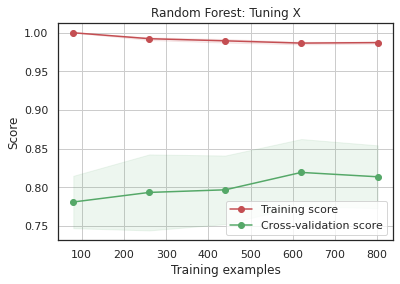

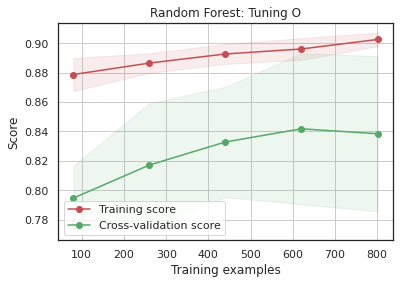

In [140]:
g = plot_learning_curve(RandomForestClassifier(random_state=random_state), 
                        "Random Forest: Tuning X", X_train, y_train, cv=10)
g = plot_learning_curve(rf_best, "Random Forest: Tuning O", X_train, y_train, cv=10)

In [141]:
cross_validator(RandomForestClassifier(random_state=random_state), X_train, y_train, n_jobs=6)
cross_validator(rf_best, X_train, y_train, n_jobs=6)

[0.778 0.865 0.753 0.82  0.854 0.831 0.798 0.753 0.854 0.865] -> 0.817 | 0.042
[0.8   0.854 0.73  0.888 0.91  0.876 0.843 0.787 0.888 0.831] -> 0.841 | 0.052


### 3rd Trial

In [149]:
rf_clf = RandomForestClassifier()
params = {"max_depth": [None],
          "max_features": [10],
          "min_samples_split": [2],
          "min_samples_leaf": [3],
          "bootstrap": [True],
          "n_estimators" :[100, 300, 500,1000,2000],
          "criterion": ["gini"]}

rf_grid_clf = GridSearchCV(rf_clf, param_grid=params, scoring='accuracy', cv=10, n_jobs=6, verbose=1)
rf_grid_clf.fit(X_train, y_train)

print(rf_grid_clf.best_params_, rf_grid_clf.best_score_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 1000} 0.840661672908864


In [150]:
rf_best = rf_grid_clf.best_estimator_

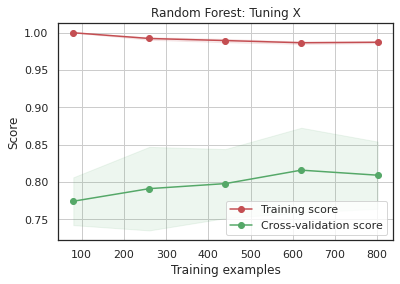

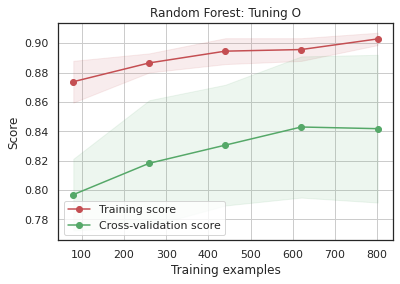

In [151]:
g = plot_learning_curve(RandomForestClassifier(), 
                        "Random Forest: Tuning X", X_train, y_train, cv=10)
g = plot_learning_curve(rf_best, "Random Forest: Tuning O", X_train, y_train, cv=10)

In [152]:
cross_validator(RandomForestClassifier(), X_train, y_train, n_jobs=6)
cross_validator(rf_best, X_train, y_train, n_jobs=6)

[0.756 0.865 0.73  0.831 0.854 0.843 0.809 0.753 0.865 0.843] -> 0.815 | 0.048
[0.811 0.854 0.73  0.888 0.91  0.876 0.831 0.787 0.876 0.831] -> 0.84 | 0.051


### 3) Light Gradient Boosting Machine (LightGBM)

### 1st Trial

In [48]:
lgbm_clf = LGBMClassifier()
params = {"max_depth": [-1, 10, 20],
          "learning_rate":[0.03, 0.1, 0.3],
          "min_child_samples": [5, 10, 20],
          "num_leaves":[31, 50],
          "subsample":[1.0],
          "colsample_bytree":[1.0],
          "reg_lambda":[0.0],
          "reg_alpha":[0.0],
          "n_estimators" :[100, 200, 300]}

lgbm_grid_clf = GridSearchCV(lgbm_clf, param_grid=params, scoring='accuracy', cv=10, n_jobs=6, verbose=1)
lgbm_grid_clf.fit(X_train, y_train)

print(lgbm_grid_clf.best_params_, lgbm_grid_clf.best_score_)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits
{'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 10, 'min_child_samples': 20, 'n_estimators': 200, 'num_leaves': 31, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0} 0.8451810237203496


In [49]:
lgbm_best = lgbm_grid_clf.best_estimator_

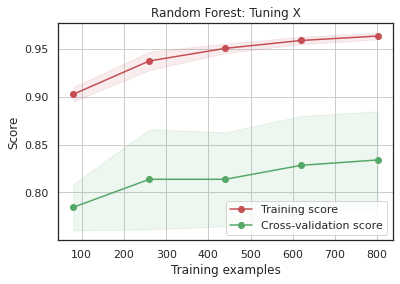

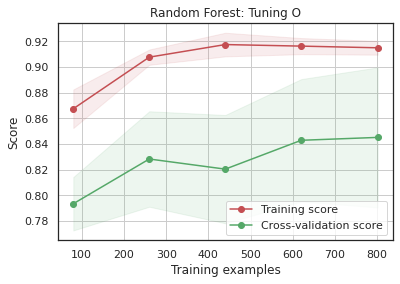

In [53]:
g = plot_learning_curve(LGBMClassifier(random_state=random_state), 
                        "Random Forest: Tuning X", X_train, y_train, cv=10)
g = plot_learning_curve(lgbm_best, "Random Forest: Tuning O", X_train, y_train, cv=10)

In [57]:
cross_validator(LGBMClassifier(randomn_State=random_state), X_train, y_train, n_jobs=6)
cross_validator(lgbm_best, X_train, y_train, n_jobs=6)

[0.8   0.843 0.742 0.865 0.888 0.865 0.854 0.764 0.899 0.843] -> 0.836 | 0.049
[0.789 0.843 0.742 0.876 0.91  0.876 0.888 0.798 0.899 0.831] -> 0.845 | 0.052


### 2nd Trial

In [58]:
lgbm_clf = LGBMClassifier()
params = {"max_depth": [-1, 10, 20],
          "learning_rate":[0.03, 0.1, 0.3],
          "min_child_samples": [5, 10, 20, 30],
          "num_leaves":[31, 50],
          "subsample":[1.0],
          "colsample_bytree":[1.0],
          "reg_lambda":[0.0],
          "reg_alpha":[0.0],
          "n_estimators" :[100, 200, 300]}

lgbm_grid_clf = GridSearchCV(lgbm_clf, param_grid=params, scoring='accuracy', cv=10, n_jobs=6, verbose=1)
lgbm_grid_clf.fit(X_train, y_train)

print(lgbm_grid_clf.best_params_, lgbm_grid_clf.best_score_)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 30, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0} 0.8463046192259676


In [59]:
lgbm_best = lgbm_grid_clf.best_estimator_

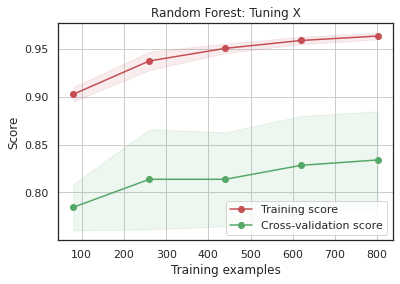

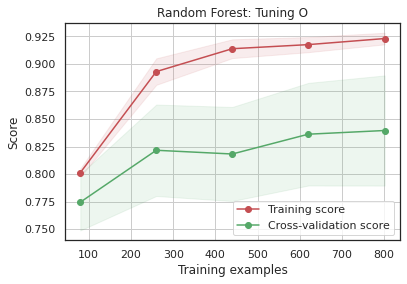

In [60]:
g = plot_learning_curve(LGBMClassifier(random_state=random_state), 
                        "Random Forest: Tuning X", X_train, y_train, cv=10)
g = plot_learning_curve(lgbm_best, "Random Forest: Tuning O", X_train, y_train, cv=10)

In [61]:
cross_validator(LGBMClassifier(randomn_State=random_state), X_train, y_train, n_jobs=6)
cross_validator(lgbm_best, X_train, y_train, n_jobs=6)

[0.8   0.843 0.742 0.865 0.888 0.865 0.854 0.764 0.899 0.843] -> 0.836 | 0.049
[0.789 0.843 0.764 0.865 0.91  0.876 0.854 0.843 0.876 0.843] -> 0.846 | 0.04


### 3rd Trial

In [75]:
lgbm_clf = LGBMClassifier()
params = {"max_depth": [10],
          "learning_rate":[0.1],
          "min_child_samples": [30],
          "num_leaves":[31],
          "subsample":[0.3, 0.5, 1.0],
          "colsample_bytree":[0.3, 0.5, 1.0],
          "reg_lambda":[0.01, 0.03, 0.1, 0.3, 1,  5, 10],
          "reg_alpha": [0.01, 0.03, 0.1, 0.3, 1, 5, 10],
          "n_estimators" :[100, 200, 300]}

lgbm_grid_clf = GridSearchCV(lgbm_clf, param_grid=params, scoring='accuracy', cv=10, n_jobs=6, verbose=1)
lgbm_grid_clf.fit(X_train, y_train)

print(lgbm_grid_clf.best_params_, lgbm_grid_clf.best_score_)

Fitting 10 folds for each of 1323 candidates, totalling 13230 fits
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 30, 'n_estimators': 200, 'num_leaves': 31, 'reg_alpha': 0.03, 'reg_lambda': 5, 'subsample': 0.3} 0.8530461922596755


In [76]:
lgbm_best = lgbm_grid_clf.best_estimator_

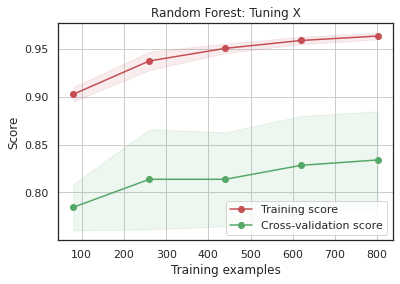

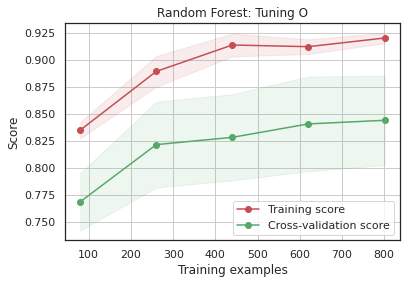

In [77]:
g = plot_learning_curve(LGBMClassifier(random_state=random_state), 
                        "Random Forest: Tuning X", X_train, y_train, cv=10)
g = plot_learning_curve(lgbm_best, "Random Forest: Tuning O", X_train, y_train, cv=10)

In [78]:
cross_validator(LGBMClassifier(randomn_State=random_state), X_train, y_train, n_jobs=6)
cross_validator(lgbm_best, X_train, y_train, n_jobs=6)

[0.8   0.843 0.742 0.865 0.888 0.865 0.854 0.764 0.899 0.843] -> 0.836 | 0.049
[0.789 0.854 0.775 0.876 0.921 0.865 0.876 0.831 0.899 0.843] -> 0.853 | 0.043


### 4th Trial

In [83]:
lgbm_clf = LGBMClassifier()
params = {"max_depth": [10],
          "learning_rate":[0.1],
          "min_child_samples": [30],
          "num_leaves":[31, 50, 100],
          "subsample":[0.3],
          "colsample_bytree":[1.0],
          "reg_lambda":[5],
          "reg_alpha": [0.03],
          "n_estimators" :[200, 300, 500, 1000]}

lgbm_grid_clf = GridSearchCV(lgbm_clf, param_grid=params, scoring='accuracy', cv=10, n_jobs=6, verbose=1)
lgbm_grid_clf.fit(X_train, y_train)

print(lgbm_grid_clf.best_params_, lgbm_grid_clf.best_score_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 30, 'n_estimators': 200, 'num_leaves': 31, 'reg_alpha': 0.03, 'reg_lambda': 5, 'subsample': 0.3} 0.8530461922596755


In [84]:
lgbm_best = lgbm_grid_clf.best_estimator_

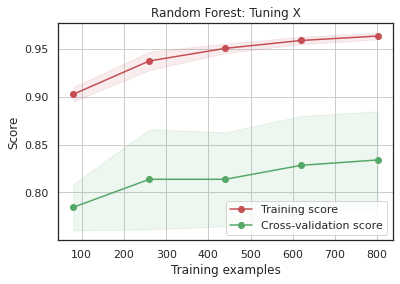

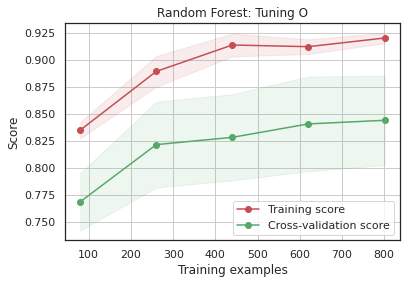

In [85]:
g = plot_learning_curve(LGBMClassifier(random_state=random_state), 
                        "Random Forest: Tuning X", X_train, y_train, cv=10)
g = plot_learning_curve(lgbm_best, "Random Forest: Tuning O", X_train, y_train, cv=10)

In [86]:
cross_validator(LGBMClassifier(randomn_State=random_state), X_train, y_train, n_jobs=6)
cross_validator(lgbm_best, X_train, y_train, n_jobs=6)

[0.8   0.843 0.742 0.865 0.888 0.865 0.854 0.764 0.899 0.843] -> 0.836 | 0.049
[0.789 0.854 0.775 0.876 0.921 0.865 0.876 0.831 0.899 0.843] -> 0.853 | 0.043


### 4) XGBoost Machine

In [87]:
xgb_clf = XGBClassifier()
params = {"max_depth": [-1, 10, 20],
          "learning_rate":[0.03, 0.1, 0.3],
          "subsample":[1.0],
          "colsample_bytree":[1.0],
          "reg_lambda":[0.0],
          "reg_alpha":[0.0],
          "n_estimators" :[100, 200, 300]}

xgb_grid_clf = GridSearchCV(xgb_clf, param_grid=params, scoring='accuracy', cv=10, n_jobs=6, verbose=1)
xgb_grid_clf.fit(X_train, y_train)

print(xgb_grid_clf.best_params_, xgb_grid_clf.best_score_)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
[16:07:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 10, 'n_estimators': 100, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0} 0.8384019975031212


In [88]:
xgb_best = xgb_grid_clf.best_estimator_

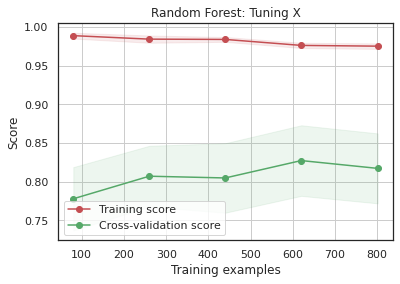

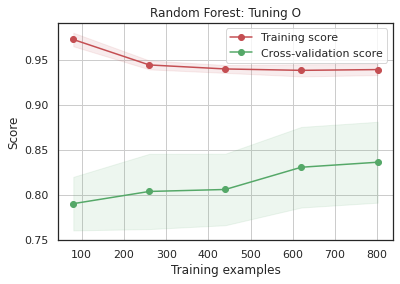

In [89]:
g = plot_learning_curve(XGBClassifier(random_state=random_state), 
                        "Random Forest: Tuning X", X_train, y_train, cv=10)
g = plot_learning_curve(xgb_best, "Random Forest: Tuning O", X_train, y_train, cv=10)

In [90]:
cross_validator(XGBClassifier(randomn_State=random_state), X_train, y_train, n_jobs=6)
cross_validator(xgb_best, X_train, y_train, n_jobs=6)

[0.767 0.843 0.73  0.854 0.888 0.809 0.831 0.753 0.843 0.831] -> 0.815 | 0.047
[0.822 0.831 0.753 0.888 0.888 0.888 0.831 0.775 0.876 0.831] -> 0.838 | 0.045


### 5) Gradient Boosting Machine

### 1st Trial

In [94]:
gb_clf = GradientBoostingClassifier()
params = {'loss' : ["deviance"],
          'n_estimators' : [100,200,300],
          'learning_rate': [0.1, 0.05, 0.01],
          'max_depth': [4, 8],
          'min_samples_leaf': [50,100,150],
          'max_features': [0.3, 0.1],
          'subsample':[0.3, 0.5, 1.0]
          }


gb_grid_clf = GridSearchCV(gb_clf, param_grid=params, scoring='accuracy', cv=10, n_jobs=6, verbose=1)
gb_grid_clf.fit(X_train, y_train)

print(gb_grid_clf.best_params_, gb_grid_clf.best_score_)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits
{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 50, 'n_estimators': 300, 'subsample': 1.0} 0.840661672908864


In [96]:
gb_best = gb_grid_clf.best_estimator_

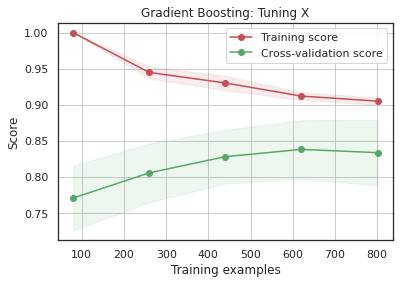

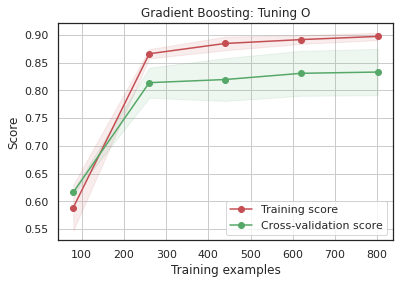

In [97]:
g = plot_learning_curve(GradientBoostingClassifier(random_state=random_state), 
                        "Gradient Boosting: Tuning X", X_train, y_train, cv=10)
g = plot_learning_curve(gb_best, "Gradient Boosting: Tuning O", X_train, y_train, cv=10)

In [99]:
cross_validator(GradientBoostingClassifier(random_state=random_state), X_train, y_train, n_jobs=6)
cross_validator(gb_best, X_train, y_train, n_jobs=6)

[0.822 0.831 0.742 0.843 0.899 0.831 0.854 0.809 0.899 0.843] -> 0.837 | 0.043
[0.8   0.854 0.742 0.854 0.899 0.865 0.831 0.809 0.876 0.831] -> 0.836 | 0.043


### 2nd Trial

In [104]:
gb_clf = GradientBoostingClassifier()
params = {'loss' : ["deviance"],
          'n_estimators' : [300, 500],
          'learning_rate': [0.1],
          'max_depth': [4, 8, 12],
          'min_samples_leaf': [50],
          'max_features': [0.8, 0.5, 0.3, 0.1],
          'subsample':[1.0]
          }


gb_grid_clf = GridSearchCV(gb_clf, param_grid=params, scoring='accuracy', cv=10, n_jobs=6, verbose=1)
gb_grid_clf.fit(X_train, y_train)

print(gb_grid_clf.best_params_, gb_grid_clf.best_score_)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 8, 'max_features': 0.8, 'min_samples_leaf': 50, 'n_estimators': 300, 'subsample': 1.0} 0.849637952559301


In [105]:
gb_best = gb_grid_clf.best_estimator_

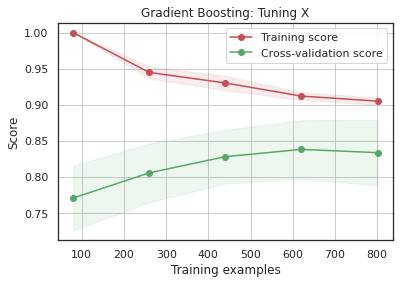

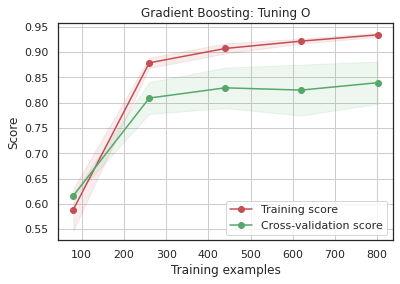

In [106]:
g = plot_learning_curve(GradientBoostingClassifier(random_state=random_state), 
                        "Gradient Boosting: Tuning X", X_train, y_train, cv=10)
g = plot_learning_curve(gb_best, "Gradient Boosting: Tuning O", X_train, y_train, cv=10)

In [107]:
cross_validator(GradientBoostingClassifier(random_state=random_state), X_train, y_train, n_jobs=6)
cross_validator(gb_best, X_train, y_train, n_jobs=6)

[0.822 0.831 0.742 0.843 0.899 0.831 0.854 0.809 0.899 0.843] -> 0.837 | 0.043
[0.811 0.876 0.742 0.854 0.888 0.888 0.843 0.809 0.899 0.843] -> 0.845 | 0.046


### 6) Extra Trees

In [109]:
ext_clf = ExtraTreesClassifier()
params = {"max_depth": [None],
          "max_features": [1, 3, 10],
          "min_samples_split": [2, 3, 10],
          "min_samples_leaf": [1, 3, 10],
          "bootstrap": [False, True],
          "n_estimators" :[100,300],
          "criterion": ["gini"]}

ext_grid_clf = GridSearchCV(ext_clf, param_grid=params, scoring='accuracy', cv=10, n_jobs=6, verbose=1)
ext_grid_clf.fit(X_train, y_train)

print(ext_grid_clf.best_params_, ext_grid_clf.best_score_)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100} 0.8361423220973784


In [110]:
ext_best = ext_grid_clf.best_estimator_

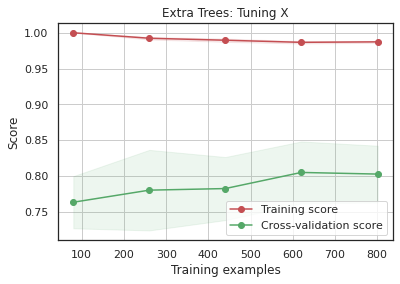

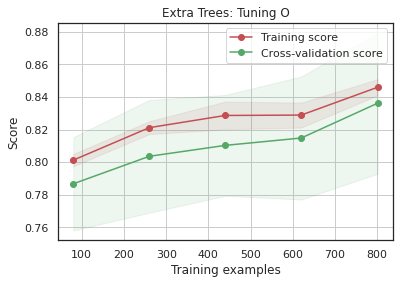

In [111]:
g = plot_learning_curve(ExtraTreesClassifier(random_state=random_state), 
                        "Extra Trees: Tuning X", X_train, y_train, cv=10)
g = plot_learning_curve(ext_best, "Extra Trees: Tuning O", X_train, y_train, cv=10)

In [112]:
cross_validator(ExtraTreesClassifier(random_state=random_state), X_train, y_train, n_jobs=6)
cross_validator(ext_best, X_train, y_train, n_jobs=6)

[0.756 0.831 0.73  0.843 0.831 0.809 0.809 0.753 0.865 0.831] -> 0.806 | 0.042
[0.844 0.843 0.764 0.876 0.899 0.831 0.831 0.775 0.865 0.854] -> 0.838 | 0.04


In [113]:
ext_clf = ExtraTreesClassifier()
params = {"max_depth": [None, 4, 8],
          "max_features": [5, 10],
          "min_samples_split": [2, 3, 10],
          "min_samples_leaf": [5, 10, 15],
          "bootstrap": [False, True],
          "n_estimators" :[100,200,300],
          "criterion": ["gini"]}

ext_grid_clf = GridSearchCV(ext_clf, param_grid=params, scoring='accuracy', cv=10, n_jobs=6, verbose=1)
ext_grid_clf.fit(X_train, y_train)

print(ext_grid_clf.best_params_, ext_grid_clf.best_score_)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits
{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 10, 'min_samples_split': 3, 'n_estimators': 200} 0.8372659176029963


In [114]:
ext_best = ext_grid_clf.best_estimator_

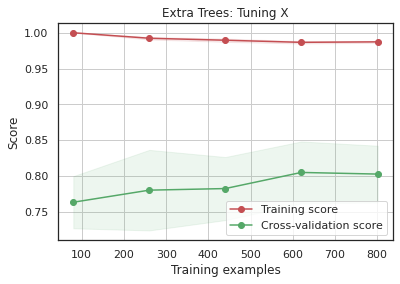

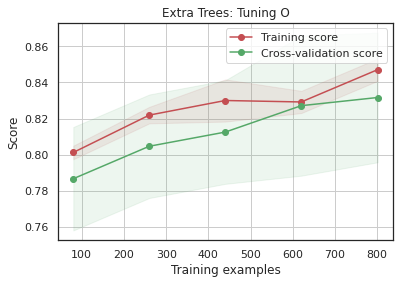

In [115]:
g = plot_learning_curve(ExtraTreesClassifier(random_state=random_state), 
                        "Extra Trees: Tuning X", X_train, y_train, cv=10)
g = plot_learning_curve(ext_best, "Extra Trees: Tuning O", X_train, y_train, cv=10)

In [116]:
cross_validator(ExtraTreesClassifier(random_state=random_state), X_train, y_train, n_jobs=6)
cross_validator(ext_best, X_train, y_train, n_jobs=6)

[0.756 0.831 0.73  0.843 0.831 0.809 0.809 0.753 0.865 0.831] -> 0.806 | 0.042
[0.833 0.831 0.764 0.865 0.876 0.843 0.831 0.775 0.865 0.865] -> 0.835 | 0.036


### 7) Support Vector Machine, SVC

In [133]:
svc_clf = SVC(probability=True)
params = {'kernel': ['rbf'], 
          'gamma': [ 0.001, 0.01, 0.1, 1],
          'C': [1, 10, 50, 100,200,300, 1000]}

svc_grid_clf = GridSearchCV(svc_clf, param_grid=params, scoring='accuracy', cv=10, n_jobs=6, verbose=1)
svc_grid_clf.fit(X_train, y_train)

print(svc_grid_clf.best_params_, svc_grid_clf.best_score_)

Fitting 10 folds for each of 28 candidates, totalling 280 fits
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'} 0.8338951310861423


In [134]:
svc_best = svc_grid_clf.best_estimator_

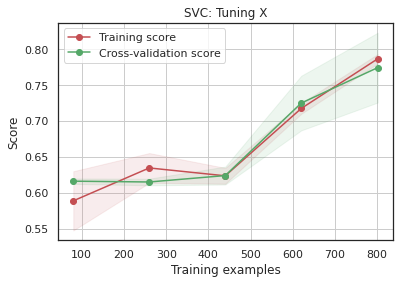

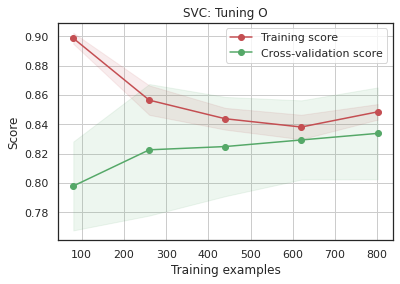

In [135]:
g = plot_learning_curve(SVC(random_state=random_state), 
                        "SVC: Tuning X", X_train, y_train, cv=10)
g = plot_learning_curve(svc_best, "SVC: Tuning O", X_train, y_train, cv=10)

In [121]:
cross_validator(SVC(random_state=random_state), X_train, y_train, n_jobs=6)
cross_validator(svc_best, X_train, y_train, n_jobs=6)

[0.711 0.73  0.719 0.854 0.775 0.775 0.809 0.73  0.843 0.798] -> 0.774 | 0.049
[0.833 0.843 0.764 0.865 0.888 0.831 0.831 0.775 0.854 0.854] -> 0.834 | 0.036


### 8) Decision Tree

In [132]:
dt_clf = DecisionTreeClassifier()
params = {"max_depth": [None, 4, 8],
          "max_features": [5, 10],
          "min_samples_split": [2, 3, 10],
          "min_samples_leaf": [5, 10, 15],
          "criterion": ["gini"]}

dt_grid_clf = grid_search(dt_clf, params, X_train, y_train, n_jobs=6)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
{'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 5, 'min_samples_split': 3} 0.8260799001248438


In [136]:
dt_best = dt_grid_clf.best_estimator_

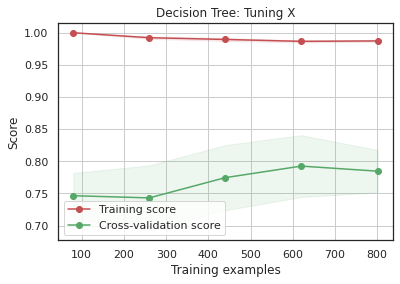

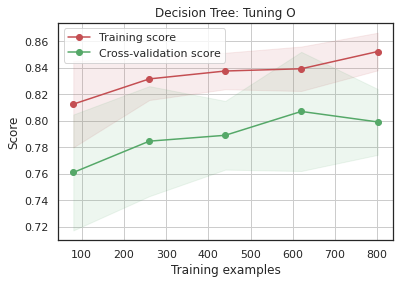

In [137]:
g = plot_learning_curve(DecisionTreeClassifier(random_state=random_state), 
                        "Decision Tree: Tuning X", X_train, y_train, cv=10)
g = plot_learning_curve(dt_best, "Decision Tree: Tuning O", X_train, y_train, cv=10)

In [138]:
cross_validator(DecisionTreeClassifier(random_state=random_state), X_train, y_train, n_jobs=6)
cross_validator(dt_best, X_train, y_train, n_jobs=6)

[0.744 0.798 0.73  0.809 0.809 0.787 0.809 0.787 0.798 0.82 ] -> 0.789 | 0.028
[0.822 0.809 0.742 0.831 0.876 0.843 0.82  0.809 0.831 0.854] -> 0.824 | 0.034


### 9) Multiple Layer Perceptron

In [48]:
mlp_clf = MLPClassifier()
params = {'hidden_layer_sizes':[(100,)],
          'activation':['logistic','relu'],
          'solver':['sgd'],
          'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10],
          'batch_size':[50, 100],
          'learning_rate':['adaptive'],
          'learning_rate_init':[0.001, 0.01, 0.1],
          'max_iter':[200]}

mlp_grid_clf = grid_search(mlp_clf, params, X_train, y_train, n_jobs=10)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 100, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'sgd'} 0.8193133583021224


In [49]:
mlp_best = mlp_grid_clf.best_estimator_

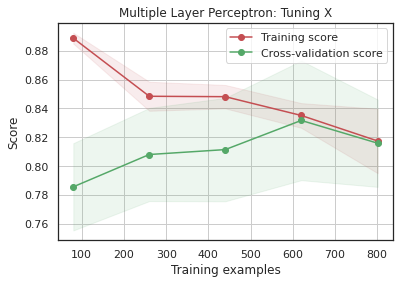

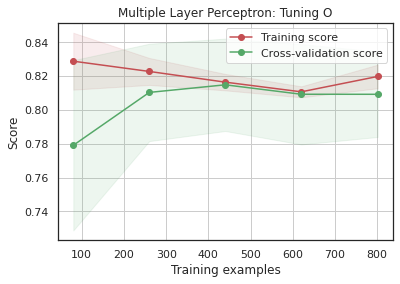

In [50]:
g = plot_learning_curve(MLPClassifier(random_state=random_state), 
                        "Multiple Layer Perceptron: Tuning X", X_train, y_train, cv=10)
g = plot_learning_curve(mlp_best, "Multiple Layer Perceptron: Tuning O", X_train, y_train, cv=10)

In [51]:
cross_validator(MLPClassifier(random_state=random_state), X_train, y_train, n_jobs=6)
cross_validator(mlp_best, X_train, y_train, n_jobs=6)

[0.822 0.798 0.764 0.865 0.82  0.764 0.798 0.809 0.843 0.854] -> 0.814 | 0.033
[0.811 0.82  0.764 0.876 0.787 0.775 0.809 0.809 0.831 0.843] -> 0.813 | 0.031


In [53]:
mlp_clf = MLPClassifier()
params = {'hidden_layer_sizes':[(10,), (50,), (100,)],
          'activation':['relu'],
          'solver':['sgd'],
          'alpha':[0.0001, 0.001],
          'batch_size':[100],
          'learning_rate':['adaptive'],
          'learning_rate_init':[0.001],
          'max_iter':[200]}

mlp_grid_clf = grid_search(mlp_clf, params, X_train, y_train, n_jobs=10)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'activation': 'relu', 'alpha': 0.001, 'batch_size': 100, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'sgd'} 0.8159176029962547


In [55]:
mlp_clf = MLPClassifier()
params = {'hidden_layer_sizes':[(50,), (50,50), (50,50,50)],
          'activation':['relu'],
          'solver':['sgd'],
          'alpha':[0.0001, 0.001],
          'batch_size':[100],
          'learning_rate':['adaptive'],
          'learning_rate_init':[0.001],
          'max_iter':[200]}

mlp_grid_clf = grid_search(mlp_clf, params, X_train, y_train, n_jobs=10)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'activation': 'relu', 'alpha': 0.001, 'batch_size': 100, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'sgd'} 0.8170536828963796


In [59]:
mlp_clf = MLPClassifier()
params = {'hidden_layer_sizes':[(200,), (200,200), (200,200,200)],
          'activation':['relu'],
          'solver':['sgd'],
          'alpha':[0.0001, 0.001],
          'batch_size':[100],
          'learning_rate':['adaptive'],
          'learning_rate_init':[0.001],
          'max_iter':[200]}

mlp_grid_clf = grid_search(mlp_clf, params, X_train, y_train, n_jobs=10)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'activation': 'relu', 'alpha': 0.001, 'batch_size': 100, 'hidden_layer_sizes': (200, 200, 200), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'sgd'} 0.8215480649188514


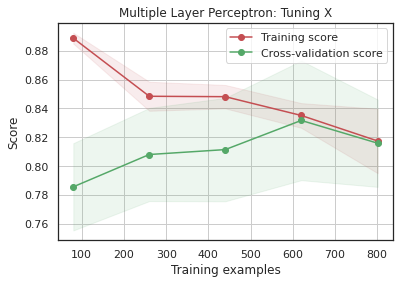

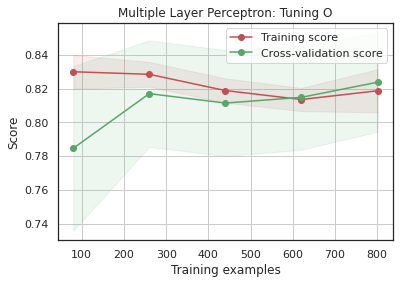

In [60]:
mlp_best = mlp_grid_clf.best_estimator_

g = plot_learning_curve(MLPClassifier(random_state=random_state), 
                        "Multiple Layer Perceptron: Tuning X", X_train, y_train, cv=10)
g = plot_learning_curve(mlp_best, "Multiple Layer Perceptron: Tuning O", X_train, y_train, cv=10)

In [61]:
cross_validator(MLPClassifier(random_state=random_state), X_train, y_train, n_jobs=6)
cross_validator(mlp_best, X_train, y_train, n_jobs=6)

[0.822 0.798 0.764 0.865 0.82  0.764 0.798 0.809 0.843 0.854] -> 0.814 | 0.033
[0.833 0.843 0.764 0.854 0.82  0.753 0.843 0.82  0.854 0.843] -> 0.823 | 0.034


## 3. Model Selection

- Ensemble, Voting, Stacking 기법을 사용하기에 앞서, 위에서 살펴본 분류모델 중 성능이 좋은 것 같은 모델 한 두개를 이용하여 예측값을 만들어보자. 
- Light Gradient Boosting Machine을 예로 사용하여 보자. 

### 1) Light Gradient Boosting Machine

In [102]:
lgbm_clf = LGBMClassifier(colsample_bytree=1.0, learning_rate=0.1, max_depth=10, 
                          min_child_samples=30, n_estimators=200, num_leaves=31, reg_alpha=0.03, reg_lambda=5, subsample=0.3)

In [89]:
cross_validator(lgbm_clf, X_train, y_train, n_jobs=6)

[0.789 0.854 0.775 0.876 0.921 0.865 0.876 0.831 0.899 0.843] -> 0.853 | 0.043


In [103]:
lgbm_clf.fit(X_train, y_train)

LGBMClassifier(max_depth=10, min_child_samples=30, n_estimators=200,
               reg_alpha=0.03, reg_lambda=5, subsample=0.3)

In [104]:
test_Survived = pd.Series(lgbm_clf.predict(test), name="Survived")
results = pd.concat([IDtest,test_Survived],axis=1)
results['Survived'] = results['Survived'].astype('int64')
results.to_csv("titanic_20210217_lgbm.csv",index=False)

### 2) SVC 

In [106]:
svc_clf = SVC(probability=True, C=10, gamma=0.01, kernel='rbf')
svc_clf.fit(X_train, y_train)

SVC(C=10, gamma=0.01, probability=True)

In [107]:
test_Survived = pd.Series(svc_clf.predict(test), name="Survived")
results = pd.concat([IDtest,test_Survived],axis=1)
results['Survived'] = results['Survived'].astype('int64')
results.to_csv("titanic_20210217_SVC.csv",index=False)